In [1]:
import os
from PIL import Image
import numpy as np
import json
import random
import torch

In [25]:
def fetch_arc_tasks(directory):
  data = []
  MAX_LENGTH = 30
  os.chdir(directory)
  files = [f for f in os.listdir() if f.endswith('json')]
  for f in files:
    with open(f, 'r') as file:
      json_file = json.loads(file.read())
      inputs = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['train']]
      outputs = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['train']]
      test_input = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['test']]
      test_output = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['test']]
      data.append(ARC_Task(inputs, outputs, test_input[0], test_output[0]))

  return data

def fetch_1d(directory):
  data = []
  MAX_LENGTH = 30
  os.chdir(directory)
  files = [f for f in os.listdir() if f.endswith('json')]
  for f in files:
    with open(f, 'r') as file:
      json_file = json.loads(file.read())
      inputs = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['train']]
      outputs = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['train']]
      test_input = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['test']]
      test_output = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['test']]
      data.append([x for x in inputs])
      data.append([x for x in outputs])
      data.append([x for x in test_input])
      data.append([x for x in test_output])

  random.shuffle(data)
  return data

def one_hot_encode(array):
  MAX_LENGTH = 30
  arr = torch.zeros((MAX_LENGTH, MAX_LENGTH, 11))
  size = array.shape
  for x in range(MAX_LENGTH):
    for y in range(MAX_LENGTH):
      if x < size[0] and y < size[1]:
        arr[x, y, array[x, y]] = 1
      else:
        arr[x, y, 10] = 1
  return arr.flatten()

In [10]:
from matplotlib.pyplot import imshow
%matplotlib inline

def collapse(tensor):
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      arr[x, y] = torch.argmax(tensor[x, y]).item()
  return arr

def visualize(tensor):
  #torch.argmax(tensor.reshape(30, 30, 11)).item()
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      arr[x, y] = torch.argmax(tensor[x, y]).item()
  convert(arr)

def visualize2(tensor):
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      difs = [torch.abs(v - tensor[x, y]) for v in color2vector]
      sums = [torch.sum(difs[i]) for i in range(11)]
      index_min = min(range(len(sums)), key=sums.__getitem__)
      #print(index_min)
      arr[x, y] = index_min
  convert(arr)

converter = {}
converter[0] = np.array([0, 0, 0])
converter[1] = np.array([0, 116, 217])
converter[2] = np.array([255, 65, 54])
converter[3] = np.array([46, 204, 64])
converter[4] = np.array([255, 220, 0])
converter[5] = np.array([170, 170, 170])
converter[6] = np.array([240, 18, 190])
converter[7] = np.array([255, 113, 27])
converter[8] = np.array([127, 219, 255])
converter[9] = np.array([135, 12, 37])
converter[10] = np.array([255, 255, 255])

def convert(X):
  Y = np.zeros(shape=(X.shape[0], X.shape[1], 3), dtype=np.uint8)
  for x in range(X.shape[0]):
    for y in range(X.shape[1]):
      Y[x, y] = converter[X[x, y]]
  imshow(Y)

In [3]:
class ARC_Task:
  def __init__(self, inputs, outputs, test_input, test_output):
    self.inputs = inputs
    self.outputs = outputs
    self.test_input = test_input
    self.test_output = test_output

In [4]:
from torch.utils.data import Dataset

class ARCDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __getitem__(self, idx):
    return self.data[idx]

  def __len__(self):
    return len(self.data)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
  def __init__(self, input_shape=30*30*11, latent_dim = 128):
    super(VAE, self).__init__()
    self.input_shape = input_shape
    self.latent_dim = latent_dim

    self.encoder_l1 = nn.Linear(self.input_shape, 64, bias=True)
    self.fc1 = nn.Linear(64, 128)
    self.fc_mu = nn.Linear(128, latent_dim)
    self.fc_log_var = nn.Linear(128, latent_dim)
    self.fc2 = nn.Linear(latent_dim, 64)
    self.decoder_l1 = nn.Linear(64, self.input_shape, bias=True)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)
    return sample

  def forward(self, x):
    task_vector = torch.zeros((1, 64))
    mu_acc = torch.zeros((1, self.latent_dim))
    log_var_acc = torch.zeros((1, self.latent_dim))
    for input, output in zip(task.inputs, task.outputs):
      latent_input, mu_input, log_var_input = self.run_encoder(input)
      latent_output, mu_output, log_var_output = self.run_encoder(output)
      task_vector += latent_output - latent_input
      mu_acc += mu_output - mu_input
      log_var_acc += log_var_output - log_var_input
    task_vector /= len(task.inputs)
    mu = mu_acc / len(task.inputs)
    log_var = log_var_acc / len(task.inputs)
    latent_prediction, _, _ = self.run_encoder(task.test_input)
    prediction = self.run_decoder(latent_prediction + task_vector)
    return prediction, mu, log_var

  def run_encoder(self, x):
    x = torch.sigmoid(self.encoder_l1(x))
    hidden = self.fc1(x)
    mu = self.fc_mu(hidden)
    log_var = self.fc_log_var(hidden)

    z = self.reparameterize(mu, log_var)
    z = self.fc2(z) # latent
    return z, mu, log_var

  def run_decoder(self, latent):
    reconstruction = torch.sigmoid(self.decoder_l1(latent))
    return reconstruction

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class Undirect_VAE(nn.Module):
  def __init__(self, input_shape=30*30*11, latent_dim = 128):
    super(Undirect_VAE, self).__init__()
    self.input_shape = input_shape
    self.latent_dim = latent_dim

    self.encoder_l1 = nn.Linear(self.input_shape, 64, bias=True)
    self.fc1 = nn.Linear(64, 128)
    self.fc_mu = nn.Linear(128, latent_dim)
    self.fc_log_var = nn.Linear(128, latent_dim)
    self.fc2 = nn.Linear(latent_dim, 64)
    self.decoder_l1 = nn.Linear(64, self.input_shape, bias=True)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)
    return sample

  def forward(self, x):
    latent, mu, log_var = self.run_encoder(x)
    prediction = self.run_decoder(latent)
    return prediction, mu, log_var

  def run_encoder(self, x):
    x = torch.sigmoid(self.encoder_l1(x))
    hidden = self.fc1(x)
    mu = self.fc_mu(hidden)
    log_var = self.fc_log_var(hidden)

    z = self.reparameterize(mu, log_var)
    z = self.fc2(z) # latent
    return z, mu, log_var

  def run_decoder(self, latent):
    reconstruction = torch.sigmoid(self.decoder_l1(latent))
    return reconstruction

In [6]:
def final_loss(loss, mu, log_var):
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return KLD + loss

In [26]:
train_dataset = ARCDataset(fetch_1d("/content/train"))
len(train_dataset)

1600

In [38]:
model = Undirect_VAE(latent_dim=500)
model.train()

Undirect_VAE(
  (encoder_l1): Linear(in_features=9900, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=500, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=64, bias=True)
  (decoder_l1): Linear(in_features=64, out_features=9900, bias=True)
)

In [ ]:
import torch.optim as optim

mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 500

for epoch in range(n_epochs):
  loss = 0

  for task in train_dataset:
    optimizer.zero_grad()
    prediction, mu, log_var = model(task)
    mse_loss = mse(prediction, task.test_output)
    train_loss = final_loss(mse_loss, mu, log_var)
    train_loss.backward()
    optimizer.step()
    loss += train_loss.item()

  if epoch % 5 == 0:
    print(epoch, loss)

In [ ]:
import torch.optim as optim

mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
n_epochs = 50

for epoch in range(n_epochs):
  loss = 0

  for task in train_dataset[0:400]:
    optimizer.zero_grad()
    prediction, mu, log_var = model(task[0])
    mse_loss = mse(prediction, task[0])
    train_loss = final_loss(mse_loss, mu, log_var)
    train_loss.backward()
    optimizer.step()
    loss += train_loss.item()

  if epoch % 5 == 0:
    print(epoch, loss)

0 7.5084149478934705
5 7.516920574940741
10 7.5167934987694025
15 7.517750315833837
20 7.51696885516867
25 7.516352977603674


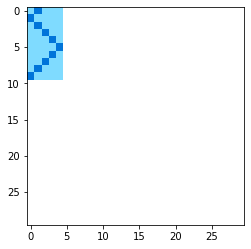

In [37]:
visualize(train_dataset[1][0].reshape(30, 30, 11))

In [ ]:
def predict_first_test(task):
  task_vector = torch.zeros(500)
  for input, output in zip(task.inputs, task.outputs):
    latent_input = model.run_encoder(one_hot_encode(input))
    latent_output = model.run_encoder(one_hot_encode(output))
    task_vector += latent_output - latent_input
  task_vector /= len(task.inputs)
  latent_prediction = model.run_encoder(one_hot_encode(task.test_inputs[0])) + task_vector
  return model.run_decoder(latent_prediction)